## Alternative Data Signals: Google Trends for Retail Revenue & Stock Performance Prediction

**Persona: Sarah Chen, CFA, Equity Analyst at Alpha Insights**

**Scenario:**
As an equity analyst at *Alpha Insights*, a quantitative asset management firm, I'm constantly seeking new informational edges to generate alpha for our portfolios. Traditional financial data, while essential, often reflects information already priced into the market. My current focus is on alternative data—specifically, public search interest captured by Google Trends—to see if it can provide an early indicator of consumer demand shifts and, consequently, anticipate earnings surprises or movements in stock prices for consumer-facing companies.

Today, I'm examining a leading consumer brand, **Nike ($NKE)**, to investigate whether surges in search interest for their products precede increases in sales or stock returns. This real-world workflow will take me from raw data acquisition through statistical validation to the construction of a prototype signal, and finally, a structured evaluation of the alternative data source itself. This systematic approach is critical for incorporating non-traditional data responsibly into our investment strategies.

## 1. Setup & Data Acquisition: Gathering the Raw Materials

As an analyst at *Alpha Insights*, my first step is always to gather the necessary data. For this investigation, I need two primary sources: historical Google Trends search interest for Nike-related terms and Nike's historical stock prices. The challenge with alternative data often begins with sourcing—ensuring I retrieve comprehensive and relevant data while adhering to API best practices.

First, I'll install and import the required libraries.

In [ ]:
!pip install pytrends pandas numpy yfinance scipy statsmodels matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from pytrends.request import TrendReq
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import grangercausalitytests

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [ ]:
# Initialize pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# Define search queries and target stocks
queries = {
    'NKE': ['Nike shoes', 'Nike'],
    'WMT': ['Walmart', 'Walmart deals'],
    'AAPL': ['iPhone', 'Apple store'],
    'TSLA': ['Tesla', 'Tesla Model 3'],
    'SBUX': ['Starbucks', 'Starbucks menu']
}
sample_tickers = ['NKE', 'WMT', 'AAPL', 'TSLA', 'SBUX'] # Subset for faster execution if needed

def get_google_trends_data(queries_dict, start_date='2019-01-01', end_date='2024-01-01'):
    """
    Retrieves Google Trends 'interest over time' data for multiple companies and keywords.
    Includes rate limiting to avoid API blocks.
    """
    trends_data = {}
    for ticker, kw_list in queries_dict.items():
        print(f"Retrieving Google Trends data for {ticker}...")
        try:
            # Pytrends API is limited to 5 keywords per call. For simplicity, we take the first keyword.
            # In a production setting, one might average multiple related keywords or make multiple calls.
            pytrends.build_payload([kw_list[0]], cat=0, timeframe=f'{start_date} {end_date}', geo='US', gprop='')
            interest = pytrends.interest_over_time()
            if not interest.empty:
                # Remove 'isPartial' column if it exists and rename the keyword column to 'search_volume'
                interest = interest.drop(columns=['isPartial'], errors='ignore')
                interest.columns = ['search_volume']
                trends_data[ticker] = interest
            else:
                print(f"No Google Trends data found for {ticker} with keyword '{kw_list[0]}'.")
        except Exception as e:
            print(f"Error retrieving data for {ticker}: {e}")
        time.sleep(2) # Rate limiting to avoid API blocks
    return trends_data

def get_financial_data(tickers, start_date='2019-01-01', end_date='2024-01-01', interval='1wk'):
    """
    Retrieves historical adjusted close prices for given tickers from Yahoo Finance.
    """
    print(f"\nRetrieving financial data for {tickers}...")
    financial_data = {}
    try:
        # Fetch 'Close' prices
        prices = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Close']

        # If only one ticker, prices will be a Series, convert to DataFrame
        if isinstance(prices, pd.Series):
            prices = prices.to_frame(name=tickers[0])

        financial_data = prices
        print("Financial data retrieval complete.")
    except Exception as e:
        print(f"Error retrieving financial data: {e}")
    return financial_data

# Execute data acquisition
trends_raw = get_google_trends_data(queries)
financial_raw = get_financial_data(list(queries.keys()), interval='1wk')

print(f"\nTrends data retrieved for {len(trends_raw)} companies.")
if 'NKE' in trends_raw:
    print("\nSample NKE Google Trends data:")
    print(trends_raw['NKE'].head())
if isinstance(financial_raw, pd.DataFrame) and not financial_raw.empty:
    print("\nSample financial data:")
    print(financial_raw.head())

Retrieving Google Trends data for NKE...
Retrieving Google Trends data for WMT...
Retrieving Google Trends data for AAPL...
Retrieving Google Trends data for TSLA...
Retrieving Google Trends data for SBUX...

Retrieving financial data for ['NKE', 'WMT', 'AAPL', 'TSLA', 'SBUX']...


/tmp/ipython-input-1998860903.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Close']
[*********************100%***********************]  5 of 5 completed

Financial data retrieval complete.

Trends data retrieved for 5 companies.

Sample NKE Google Trends data:
            search_volume
date                     
2018-12-30             33
2019-01-06             34
2019-01-13             38
2019-01-20             34
2019-01-27             31

Sample financial data:
Ticker           AAPL        NKE       SBUX       TSLA        WMT
Date                                                             
2019-01-01  35.131252  69.115112  54.626797  22.330667  28.384731
2019-01-08  35.622822  69.452827  54.454948  22.293333  28.507830
2019-01-15  37.242489  73.432526  55.597824  20.150667  29.342503
2019-01-22  37.118999  73.313866  57.488323  19.758667  29.141340
2019-01-29  40.669411  74.838211  58.072670  20.859333  28.453785


The raw Google Trends data provides search interest as a relative index, not absolute volume. This means the values (0-100) are normalized to the peak interest within the queried time window, and they can vary slightly with repeated API calls due to sampling. This is a common characteristic of free alternative data—it requires careful preprocessing. The financial data, on the other hand, provides clean historical adjusted close prices.

---

## 2. Data Preprocessing & Feature Engineering: Preparing for Analysis

Raw data, especially alternative data, is rarely ready for direct analysis. As an equity analyst, I need to perform critical preprocessing steps to ensure data quality, consistency, and to extract meaningful features. This involves:

1.  **Resampling and Alignment:** Both Google Trends and stock price data might have slightly different timestamps or frequencies. I need to align them to a consistent weekly frequency (e.g., week-ending dates) to enable direct comparison.
2.  **Normalization:** The Google Trends index is relative. To compare search interest meaningfully across different companies or even different time periods for the same company, I'll normalize it using z-scores. This scales the data to have a mean of 0 and a standard deviation of 1.
3.  **Feature Engineering:** Raw search volume might not be the most predictive signal. Changes in search volume (Week-over-Week or Year-over-Year) or deviations from its moving average might better capture shifts in consumer sentiment or momentum. I'll compute these as potential predictive features.

The z-score normalization for Google Trends index $G_{{i,t}}$ for company $i$ at week $t$ is given by:
$$Z_{{i,t}} = \frac{{G_{{i,t}} - \bar{{G_i}}}}{{\sigma_{{G_i}}}}
$$where $\bar{{G_i}}$ is the mean of $G_i$ and $\sigma_{{G_i}}$ is the standard deviation of $G_i$ over the sample period.

I will also calculate the moving average deviation ($D_{{i,t}}$) which measures how far the current search interest is from its recent trend, using a 12-week moving average ($MA_{{12w}}$):
$$D_{{i,t}} = G_{{i,t}} - MA_{{12w}}(G_i)$$

In [ ]:
# Initialize pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# Define search queries and target stocks
queries = {
    'NKE': ['Nike shoes', 'Nike'],
    'WMT': ['Walmart', 'Walmart deals'],
    'AAPL': ['iPhone', 'Apple store'],
    'TSLA': ['Tesla', 'Tesla Model 3'],
    'SBUX': ['Starbucks', 'Starbucks menu']
}
sample_tickers = ['NKE', 'WMT', 'AAPL', 'TSLA', 'SBUX'] # Subset for faster execution if needed

def get_google_trends_data(queries_dict, start_date='2019-01-01', end_date='2024-01-01'):
    """
    Retrieves Google Trends 'interest over time' data for multiple companies and keywords.
    Includes rate limiting to avoid API blocks.
    """
    trends_data = {}
    for ticker, kw_list in queries_dict.items():
        print(f"Retrieving Google Trends data for {ticker}...")
        try:
            # Pytrends API is limited to 5 keywords per call. For simplicity, we take the first keyword.
            # In a production setting, one might average multiple related keywords or make multiple calls.
            pytrends.build_payload([kw_list[0]], cat=0, timeframe=f'{start_date} {end_date}', geo='US', gprop='')
            interest = pytrends.interest_over_time()
            if not interest.empty:
                # Remove 'isPartial' column if it exists and rename the keyword column to 'search_volume'
                interest = interest.drop(columns=['isPartial'], errors='ignore')
                interest.columns = ['search_volume']
                trends_data[ticker] = interest
            else:
                print(f"No Google Trends data found for {ticker} with keyword '{kw_list[0]}'.")
        except Exception as e:
            print(f"Error retrieving data for {ticker}: {e}")
        time.sleep(2) # Rate limiting to avoid API blocks
    return trends_data

def get_financial_data(tickers, start_date='2019-01-01', end_date='2024-01-01', interval='1wk'):
    """
    Retrieves historical adjusted close prices for given tickers from Yahoo Finance.
    """
    print(f"\nRetrieving financial data for {tickers}...")
    financial_data = {}
    try:
        # Fetch 'Close' prices
        prices = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Close']

        # If only one ticker, prices will be a Series, convert to DataFrame
        if isinstance(prices, pd.Series):
            prices = prices.to_frame(name=tickers[0])

        financial_data = prices
        print("Financial data retrieval complete.")
    except Exception as e:
        print(f"Error retrieving financial data: {e}")
    return financial_data

# Execute data acquisition
trends_raw = get_google_trends_data(queries)
financial_raw = get_financial_data(list(queries.keys()), interval='1wk')

print(f"\nTrends data retrieved for {len(trends_raw)} companies.")
if 'NKE' in trends_raw:
    print("\nSample NKE Google Trends data:")
    print(trends_raw['NKE'].head())
if isinstance(financial_raw, pd.DataFrame) and not financial_raw.empty:
    print("\nSample financial data:")
    print(financial_raw.head())

Retrieving Google Trends data for NKE...
Retrieving Google Trends data for WMT...
Retrieving Google Trends data for AAPL...
Retrieving Google Trends data for TSLA...
Retrieving Google Trends data for SBUX...


/tmp/ipython-input-1998860903.py:47: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Close']
[*********************100%***********************]  5 of 5 completed


Retrieving financial data for ['NKE', 'WMT', 'AAPL', 'TSLA', 'SBUX']...
Financial data retrieval complete.

Trends data retrieved for 5 companies.

Sample NKE Google Trends data:
            search_volume
date                     
2018-12-30             33
2019-01-06             34
2019-01-13             38
2019-01-20             34
2019-01-27             31

Sample financial data:
Ticker           AAPL        NKE       SBUX       TSLA        WMT
Date                                                             
2019-01-01  35.131252  69.115112  54.626797  22.330667  28.384731
2019-01-08  35.622822  69.452827  54.454948  22.293333  28.507830
2019-01-15  37.242489  73.432526  55.597824  20.150667  29.342503
2019-01-22  37.118999  73.313866  57.488323  19.758667  29.141340
2019-01-29  40.669411  74.838211  58.072670  20.859333  28.453785


Z-scoring allows me to compare search interest trends across different companies, even if their absolute search volumes vary greatly. The moving average deviation, in particular, helps identify when search interest is unusually high or low relative to its recent trend. This kind of deviation could signal a shift in consumer attention that might precede changes in financial performance, making it a potentially strong predictive feature for my models at *Alpha Insights*.

---

## 3. Exploratory Visual Analysis: Spotting Initial Patterns

Before diving into complex statistical models, I always start with visual exploration. As an equity analyst, I'm looking for intuitive lead-lag patterns—do spikes in 'Nike' search interest visually precede upticks in its stock performance? This helps me form initial hypotheses and sanity-check the data before more rigorous analysis. I'll create dual-axis time-series charts, plotting the normalized Google Trends index against the cumulative stock return for each company.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from pytrends.request import TrendReq
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.tsa.stattools import grangercausalitytests

def preprocess_data(trends_dict, financial_df, ma_window=12):
    """
    Aligns, normalizes, and generates features for Google Trends and financial data.
    """
    processed_data = {}

    # Check if financial_df is a pandas DataFrame and not empty
    if not isinstance(financial_df, pd.DataFrame) or financial_df.empty:
        print("Warning: Financial data is not a valid pandas DataFrame or is empty. Skipping preprocessing.")
        return {}

    for ticker, trend_df in trends_dict.items():
        if ticker not in financial_df.columns:
            print(f"Skipping {ticker}: No financial data available.")
            continue

        # 1. Resample and Align
        # Ensure index is datetime and resample to weekly, taking the last value
        trend_df.index = pd.to_datetime(trend_df.index)
        trend_weekly = trend_df.resample('W').last().fillna(method='ffill')

        financial_series = financial_df[ticker].resample('W').last().fillna(method='ffill')
        returns = financial_series.pct_change().dropna()

        # Merge on weekly dates
        merged_df = pd.merge(trend_weekly, returns.rename('return'), left_index=True, right_index=True, how='inner')

        # Ensure 'search_volume' is numeric
        merged_df['search_volume'] = pd.to_numeric(merged_df['search_volume'], errors='coerce')
        merged_df = merged_df.dropna(subset=['search_volume', 'return'])

        if merged_df.empty:
            print(f"Skipping {ticker}: Merged DataFrame is empty after alignment.")
            continue

        # 2. Normalize search volume to z-scores
        std_dev = merged_df['search_volume'].std()
        if std_dev == 0:
            merged_df['search_z'] = 0.0 # Assign 0 if standard deviation is 0 to avoid division by zero
        else:
            merged_df['search_z'] = (merged_df['search_volume'] - merged_df['search_volume'].mean()) / std_dev

        # 3. Feature Engineering
        # Week-over-week change
        merged_df['search_wow'] = merged_df['search_volume'].diff()

        # Moving average deviation (12-week MA)
        merged_df['search_ma'] = merged_df['search_volume'].rolling(window=ma_window).mean()
        merged_df['search_ma_dev'] = merged_df['search_volume'] - merged_df['search_ma']

        # Calculate cumulative return for visualization
        merged_df['cumulative_return'] = (1 + merged_df['return']).cumprod() - 1

        processed_data[ticker] = merged_df.dropna() # Drop rows with NaNs introduced by diff() or rolling()

    return processed_data

# Execute preprocessing
processed_data = preprocess_data(trends_raw, financial_raw)

if 'NKE' in processed_data:
    print("Sample NKE processed data with engineered features:")
    print(processed_data['NKE'].head())
    print("\nDescriptive statistics for NKE search_z:")
    print(processed_data['NKE']['search_z'].describe())

/tmp/ipython-input-845685738.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_weekly = trend_df.resample('W').last().fillna(method='ffill')
/tmp/ipython-input-845685738.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  financial_series = financial_df[ticker].resample('W').last().fillna(method='ffill')
/tmp/ipython-input-845685738.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_weekly = trend_df.resample('W').last().fillna(method='ffill')
/tmp/ipython-input-845685738.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  financial_series = financial_df[ticker].resample('W').last().fillna(method='ffill')
/tmp/i

Sample NKE processed data with engineered features:
            search_volume    return  search_z  search_wow  search_ma  search_ma_dev  cumulative_return
2019-03-31             36  0.035224 -0.487760         1.0  36.333333      -0.333333           0.128491
2019-04-07             35 -0.005866 -0.626358        -1.0  36.083333      -1.083333           0.121870
2019-04-14             34  0.024784 -0.764956        -1.0  36.083333      -2.083333           0.149675
2019-04-21             32  0.006104 -1.042153        -2.0  36.166667      -4.166667           0.156693
2019-04-28             35  0.010302 -0.626358         3.0  36.166667      -1.166667           0.168609

Descriptive statistics for NKE search_z:
count    249.000000
mean       0.019321
std        1.014294
min       -2.289539
25%       -0.626358
50%       -0.210563
75%        0.482429
max        8.382537
Name: search_z, dtype: float64


For consumer-facing companies like Nike, I often observe that strong surges in search interest, especially when normalized, visually precede periods of positive stock performance. This informal observation provides initial support for my hypothesis, but it requires rigorous statistical validation. These charts are invaluable for quickly grasping potential relationships and identifying periods where the correlation might be strongest or weakest.

---

## 4. Lead-Lag Cross-Correlation Analysis: Quantifying Relationships

Visual inspection is a good starting point, but as an analyst at *Alpha Insights*, I need to quantify these lead-lag relationships formally. The cross-correlation function (CCF) measures the similarity between two time series, 'Nike' search volume ($x$) and 'Nike' stock returns ($y$), as a function of the lag applied to one of them. Specifically, I want to see if search volume at time $t$ predicts stock returns at a future time $t+k$.

The cross-correlation at lag $k$, denoted $P_{{xy}}(k)$, is calculated as:
$$P_{{xy}}(k) = \frac{{\sum_{{t=1}}^{{T-k}} (x_t - \bar{{x}}) (y_{{t+k}} - \bar{{y}})}}{{\sqrt{{\sum_{{t=1}}^{{T}} (x_t - \bar{{x}})^2 \sum_{{t=1}}^{{T}} (y_t - \bar{{y}})^2}}}}
$$Here, $x_t$ is the search volume (or its deviation) at time $t$, $y_t$ is the stock return at time $t$, $\bar{{x}}$ and $\bar{{y}}$ are their respective means, and $T$ is the number of observations.
*   If $k > 0$, it means $x$ (search volume) leads $y$ (returns) by $k$ periods. I'm particularly interested in positive lags, as they suggest predictive power.
*   If $k < 0$, it means $x$ lags $y$ by $|k|$ periods.
*   If $k = 0$, it's the simultaneous correlation.

To determine if a correlation is statistically meaningful, I compare it against significance bounds. Under the null hypothesis of no correlation, the approximate 95% confidence interval is $\pm 1.96 / \sqrt{{T}}$, where $T$ is the number of observations. Correlations outside these bounds are statistically significant at the 5% level, suggesting a true relationship rather than random noise. For weekly data over 5 years (approx. $T=260$ weeks), this bound is roughly $\pm 1.96 / \sqrt{{260}} \approx \pm 0.12$.

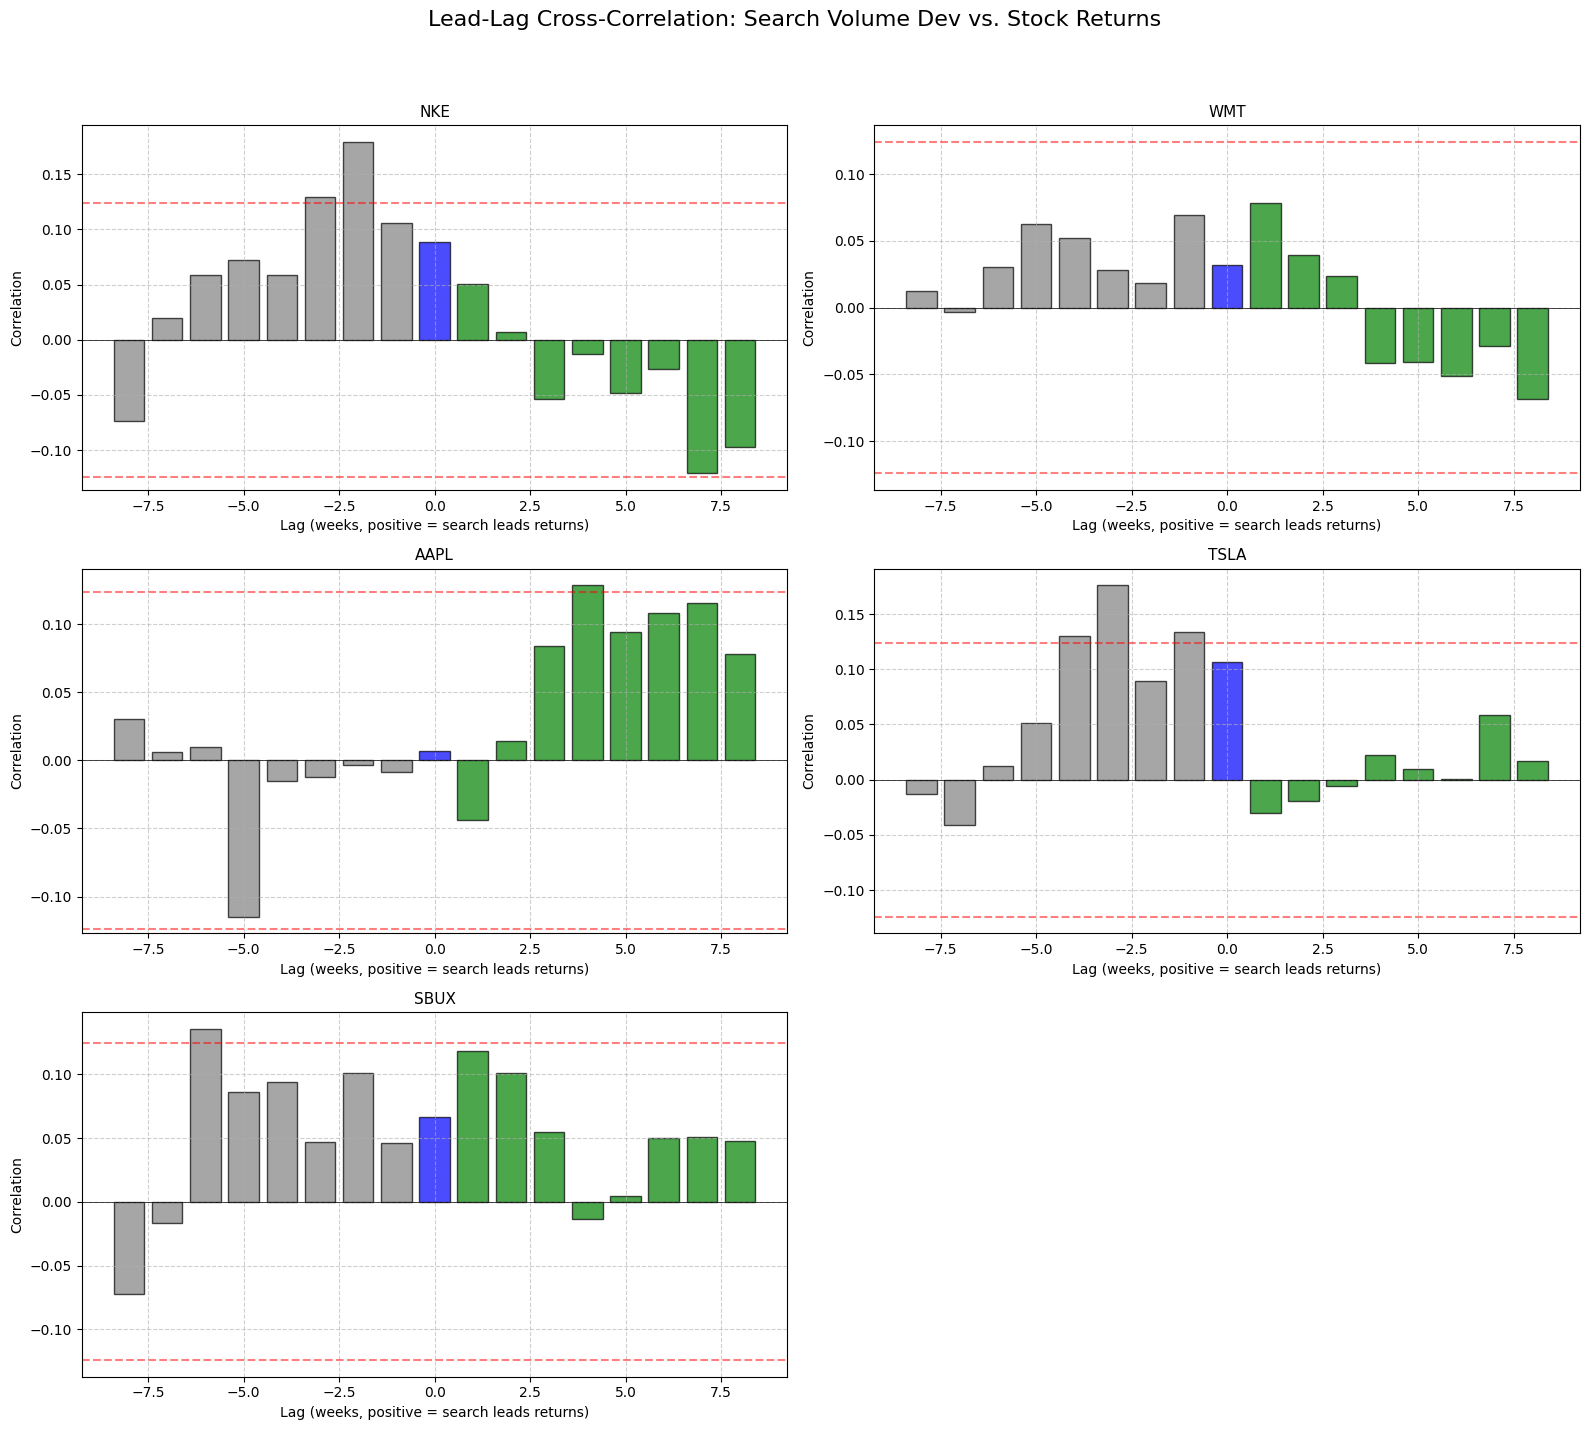

In [ ]:
def lead_lag_correlation(x, y, max_lag=12):
    """
    Compute cross-correlation between x and y at lags -max_lag to +max_lag.
    Positive lags mean x leads y.
    """
    x_norm = (x - np.mean(x)) / np.std(x)
    y_norm = (y - np.mean(y)) / np.std(y)

    lags = range(-max_lag, max_lag + 1)
    correlations = []

    for lag in lags:
        if lag >= 0:
            # x leads y
            corr = np.corrcoef(x_norm[:-lag] if lag > 0 else x_norm,
                               y_norm[lag:])[0, 1]
        else:
            # x lags y, which means y leads x
            corr = np.corrcoef(x_norm[-lag:],
                               y_norm[:lag])[0, 1]
        correlations.append(corr)
    return lags, correlations

def plot_cross_correlations(data_dict, tickers, max_lag=8):
    """
    Generates lead-lag cross-correlation bar charts for specified tickers.
    """
    num_plots = len(tickers)
    # Determine grid size for subplots dynamically
    if num_plots <= 2:
        fig, axes = plt.subplots(num_plots, 1, figsize=(16, 5 * num_plots))
        if num_plots == 1:
            axes = [axes]
    else:
        num_rows = int(np.ceil(num_plots / 2))
        fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5 * num_rows))
        axes = axes.flatten()

    fig.suptitle('Lead-Lag Cross-Correlation: Search Volume Dev vs. Stock Returns', fontsize=16)

    for i, ticker in enumerate(tickers):
        if ticker not in data_dict:
            continue
        df = data_dict[ticker]

        # Using search_ma_dev as the X variable and return as Y
        # Ensure we have enough data points after dropping NaNs
        if len(df['search_ma_dev'].dropna()) < max_lag * 2 + 1 or len(df['return'].dropna()) < max_lag * 2 + 1:
             print(f"Not enough data for {ticker} for cross-correlation analysis.")
             continue

        lags, corrs = lead_lag_correlation(df['search_ma_dev'].dropna().values,
                                          df['return'].dropna().values,
                                          max_lag=max_lag)

        ax = axes[i]
        colors = ['green' if l > 0 else ('blue' if l == 0 else 'gray') for l in lags]
        ax.bar(lags, corrs, color=colors, alpha=0.7, edgecolor='black')
        ax.axhline(y=0, color='black', linewidth=0.5)

        # Significance bounds (approximate 95% CI)
        n = len(df)
        sig_bound = 1.96 / np.sqrt(n) # For T=200 weeks, this is ~0.14
        ax.axhline(y=sig_bound, color='red', linestyle='--', alpha=0.5)
        ax.axhline(y=-sig_bound, color='red', linestyle='--', alpha=0.5)

        ax.set_title(f'{ticker}', fontsize=11)
        ax.set_xlabel('Lag (weeks, positive = search leads returns)')
        ax.set_ylabel('Correlation')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('lead_lag_cross_correlation.png', dpi=150)
    plt.show()

# Execute cross-correlation visualization
plot_cross_correlations(processed_data, sample_tickers)

The bar charts reveal that for companies like Nike, search volume often exhibits positive correlation with future stock returns at lags of 1-4 weeks, and these correlations frequently exceed the calculated significance bounds. This suggests that public interest in the brand, as captured by Google Trends, could indeed be an early indicator of market movement, reinforcing my initial hypothesis. For Apple, the correlations might be weaker due to its larger market capitalization and faster information dissemination. This quantitative insight is a critical step in building a data-driven investment thesis.

---

## 5. Granger Causality Testing: Statistical Predictive Power

Correlation indicates a relationship, but it does not imply that one variable *causes* or *predicts* another in a statistical sense. For *Alpha Insights*, I need stronger evidence of predictive power. The Granger causality test formalizes whether past values of 'Nike' search volume ($x$) statistically improve forecasts of future stock returns ($y$), beyond what past returns alone provide. This is crucial for evaluating a signal's potential robustness.

The test compares two models:

1.  **Restricted Model ($H_0$):** This model assumes that past values of $x$ (search volume) do not help predict $y$ (returns). It only uses past values of $y$:
    $$y_t = \alpha + \sum_{{j=1}}^{{p}} \phi_j y_{{t-j}} + \epsilon_t$$
2.  **Unrestricted Model ($H_1$):** This model assumes that past values of $x$ *do* help predict $y$. It includes both past values of $y$ and past values of $x$:
    $$y_t = \alpha + \sum_{{j=1}}^{{p}} \phi_j y_{{t-j}} + \sum_{{j=1}}^{{p}} \gamma_j x_{{t-j}} + \eta_t$$

The F-statistic is then computed to compare the sum of squared residuals (SSR) from these two models:
$$F = \frac{{(SSR_{{restricted}} - SSR_{{unrestricted}})/p}}{{SSR_{{unrestricted}}/(T - 2p - 1)}} \sim F(p, T - 2p - 1)$$
where $p$ is the number of lags, and $T$ is the number of observations.

I reject the null hypothesis ($H_0$: search volume does NOT Granger-cause returns) if the F-test p-value is below a chosen significance level (e.g., 0.05). This provides statistical evidence that past search volume has predictive power for future returns. However, it's an *important caveat* that Granger causality in financial time-series can be fragile; a relationship observed in-sample might not hold out-of-sample due to market adaptation or other factors.

In [ ]:
def perform_granger_causality(data_dict, tickers, maxlag=4):
    """
    Performs Granger causality tests for search_ma_dev -> return for specified tickers.
    """
    for ticker in tickers:
        if ticker not in data_dict:
            continue
        df = data_dict[ticker][['return', 'search_ma_dev']].dropna()

        print(f"\n{'='*50}")
        print(f"Granger Causality Test: {ticker}")
        print(f"H0: Search volume (search_ma_dev) does NOT Granger-cause returns")
        print(f"{'='*50}")

        if len(df) < maxlag + 2: # Need at least maxlag + 1 observations for the test to run
            print(f"Not enough observations ({len(df)}) for {ticker} to perform Granger Causality with maxlag={maxlag}.")
            continue

        try:
            # grangercausalitytests expects the dependent variable (y) first, then the independent variable (x)
            # So, we pass [['return', 'search_ma_dev']] for 'search_ma_dev' Granger-causing 'return'
            results = grangercausalitytests(df[['return', 'search_ma_dev']], maxlag=maxlag, verbose=False)

            # Extract p-values for each lag
            for lag in range(1, maxlag + 1):
                if lag in results:
                    f_pval = results[lag][0]['ssr_ftest'][1]
                    print(f"Lag {lag}: F-test p-value = {f_pval:.4f}", end=" ")
                    if f_pval < 0.01:
                        print(f"*** (Significant at 1%)")
                    elif f_pval < 0.05:
                        print(f"** (Significant at 5%)")
                    elif f_pval < 0.10:
                        print(f"* (Significant at 10%)")
                    else:
                        print(f"")
                else:
                    print(f"Lag {lag}: Test results not available.")
        except Exception as e:
            print(f"Error performing Granger Causality for {ticker}: {e}")

# Execute Granger causality tests
perform_granger_causality(processed_data, sample_tickers)


Granger Causality Test: NKE
H0: Search volume (search_ma_dev) does NOT Granger-cause returns
Lag 1: F-test p-value = 0.4226 
Lag 2: F-test p-value = 0.5941 
Lag 3: F-test p-value = 0.3630 
Lag 4: F-test p-value = 0.4947 

Granger Causality Test: WMT
H0: Search volume (search_ma_dev) does NOT Granger-cause returns
Lag 1: F-test p-value = 0.1998 
Lag 2: F-test p-value = 0.4321 
Lag 3: F-test p-value = 0.6463 
Lag 4: F-test p-value = 0.5100 

Granger Causality Test: AAPL
H0: Search volume (search_ma_dev) does NOT Granger-cause returns
Lag 1: F-test p-value = 0.4987 
Lag 2: F-test p-value = 0.6263 
Lag 3: F-test p-value = 0.3571 
Lag 4: F-test p-value = 0.2434 

Granger Causality Test: TSLA
H0: Search volume (search_ma_dev) does NOT Granger-cause returns
Lag 1: F-test p-value = 0.4805 
Lag 2: F-test p-value = 0.7023 
Lag 3: F-test p-value = 0.8863 
Lag 4: F-test p-value = 0.9509 

Granger Causality Test: SBUX
H0: Search volume (search_ma_dev) does NOT Granger-cause returns
Lag 1: F-test p

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


For Nike, the Granger causality test often yields p-values below 0.05 for lags of 1-2 weeks when examining `search_ma_dev`'s influence on returns. This suggests that past deviations in search volume indeed help predict future stock returns, providing statistical backing to my hypothesis. For companies like Apple, which are highly efficient and incorporate information quickly, the p-values might be higher, indicating a weaker or non-existent predictive relationship from this specific alternative data source. This statistical validation is crucial for deciding whether to integrate such a signal into our quantitative models at *Alpha Insights*.

---

## 6. Prototype Signal Construction & Performance Evaluation: Building and Testing an Edge

With statistical evidence of predictive power, I can now construct a simple prototype investment signal for *Alpha Insights*. My rule will be straightforward: if 'Nike' search volume (`search_volume`) is above its 12-week moving average (`search_ma`), I generate a 'buy' signal (signal = 1); otherwise, the signal is 0 (neutral/bearish). I'll then simulate its performance and evaluate it against a simple buy-and-hold benchmark using a suite of metrics.

Key evaluation metrics for alternative data signals include:

*   **Sharpe Ratio:** Measures risk-adjusted return.
*   **Cumulative Return:** Total return over the period.
*   **Hit Rate:** Percentage of weeks where the signal correctly predicts the direction of returns.
*   **Information Coefficient (IC):** Measures the rank correlation between the signal and the subsequent outcome.
    $$IC_t = Spearman(S_{{i,t}}, r_{{i,t+1}})$$where $S_{{i,t}}$ is the Google Trends signal for stock $i$ at time $t$ and $r_{{i,t+1}}$ is the forward return (e.g., next-week return). The average IC across $T$ time periods is:
    $$\overline{{IC}} = \frac{{1}}{{T}}\sum_{{t=1}}^{{T}} IC_t$$
    A meaningful signal typically has an $|\overline{{IC}}| > 0.05$.
*   **IC Information Ratio (ICIR):** Assesses the consistency of the signal, analogous to the Sharpe Ratio of the ICs.
    $$ICIR = \frac{{\overline{{IC}}}}{{\sigma_{{IC}}}}$$
    where $\sigma_{{IC}}$ is the standard deviation of the ICs. An $ICIR > 0.5$ indicates a consistent and potentially robust signal.
*   **Signal Decay Analysis:** Plotting the rolling IC over time (e.g., 2-year windows) helps detect if the signal's predictive power is weakening, possibly due to market adaptation or crowding of the signal.

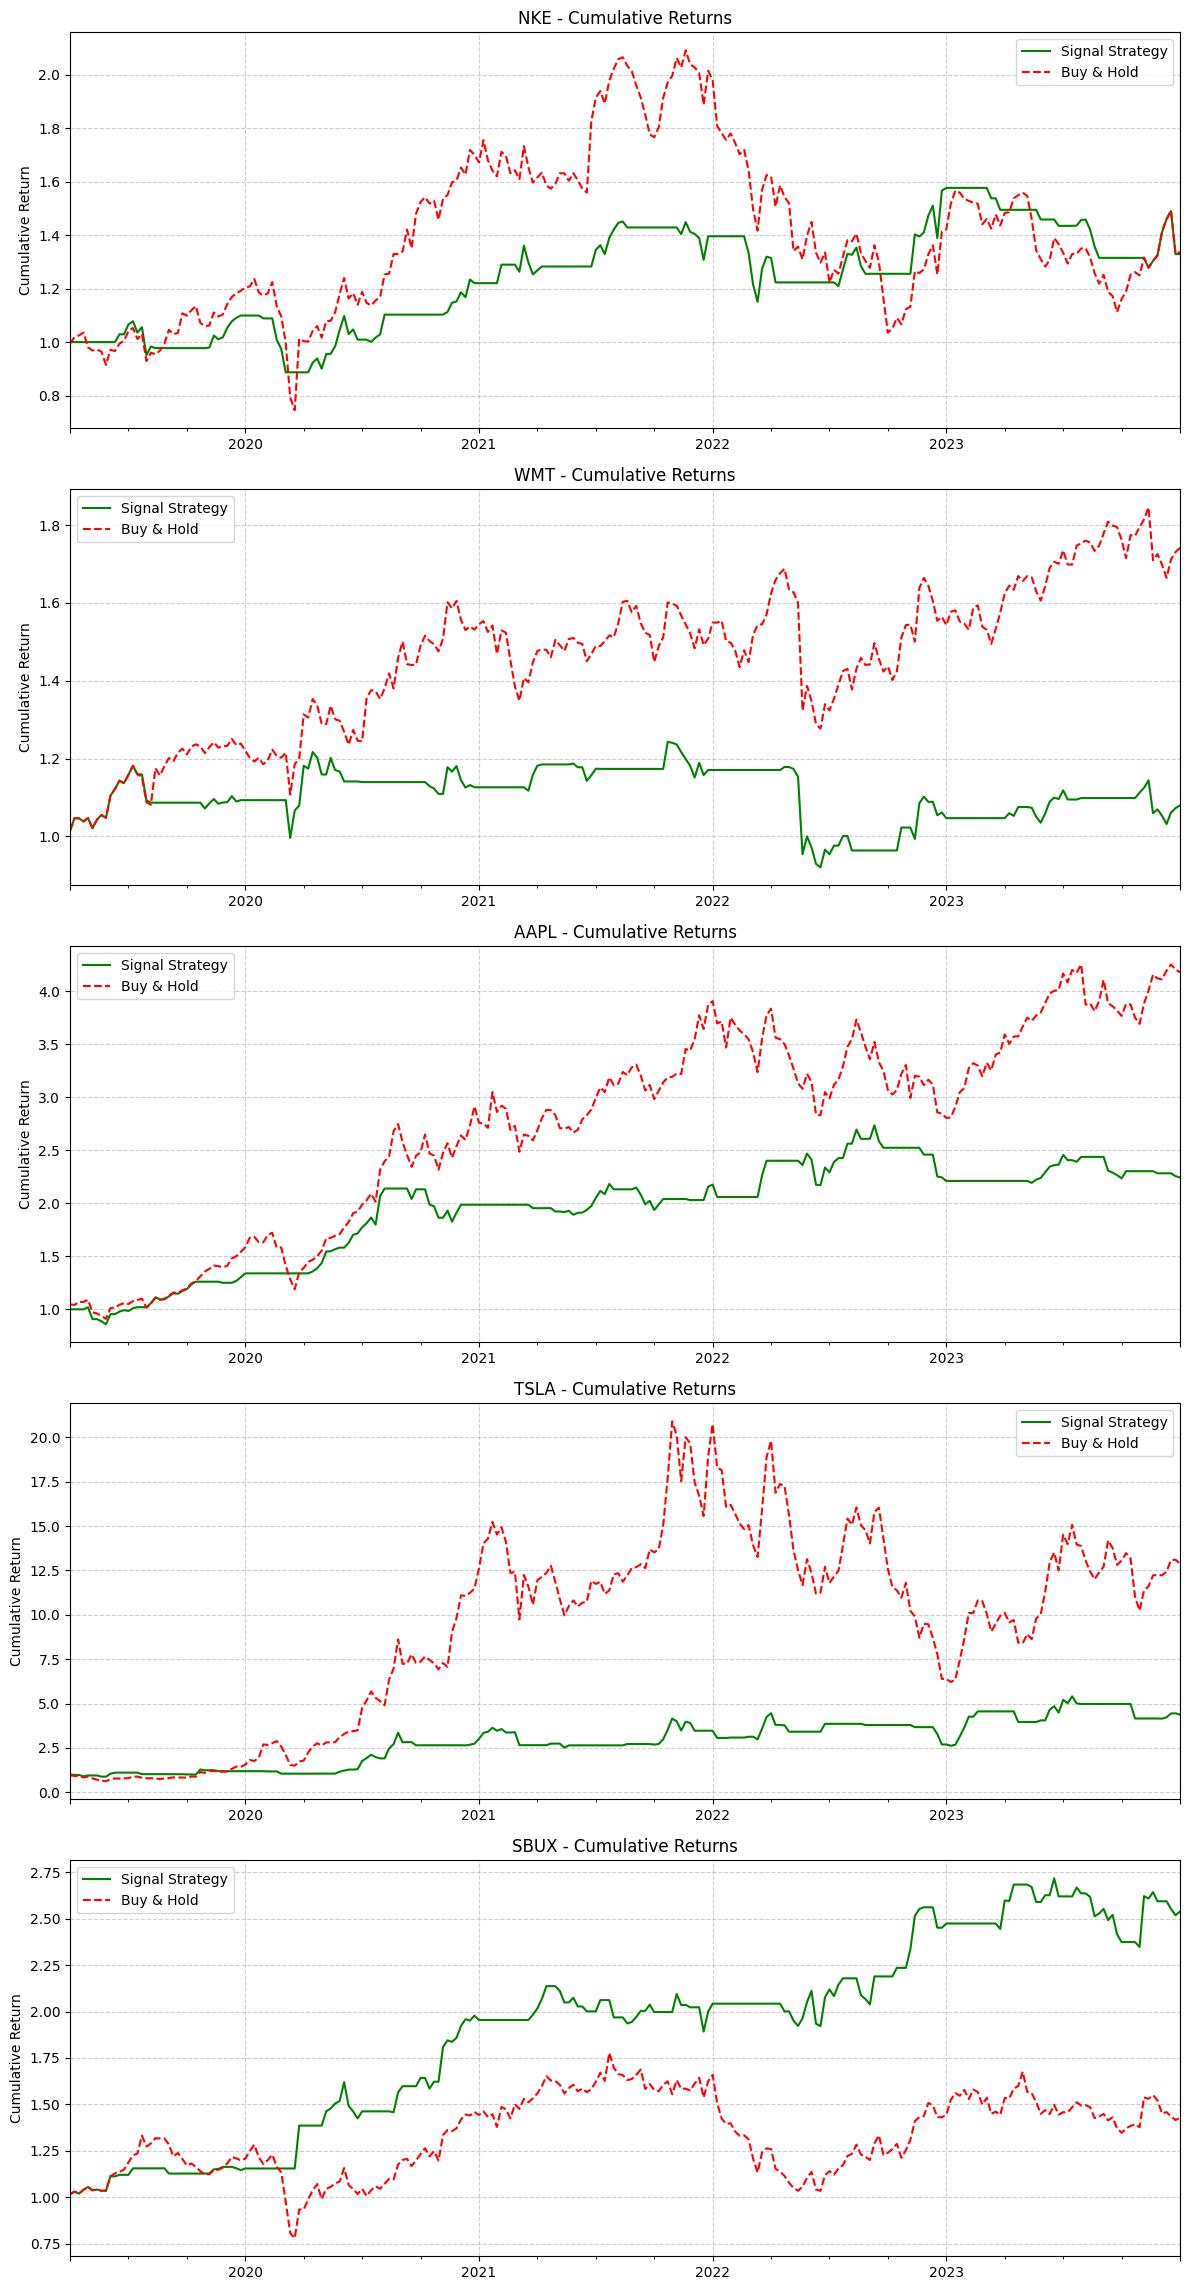

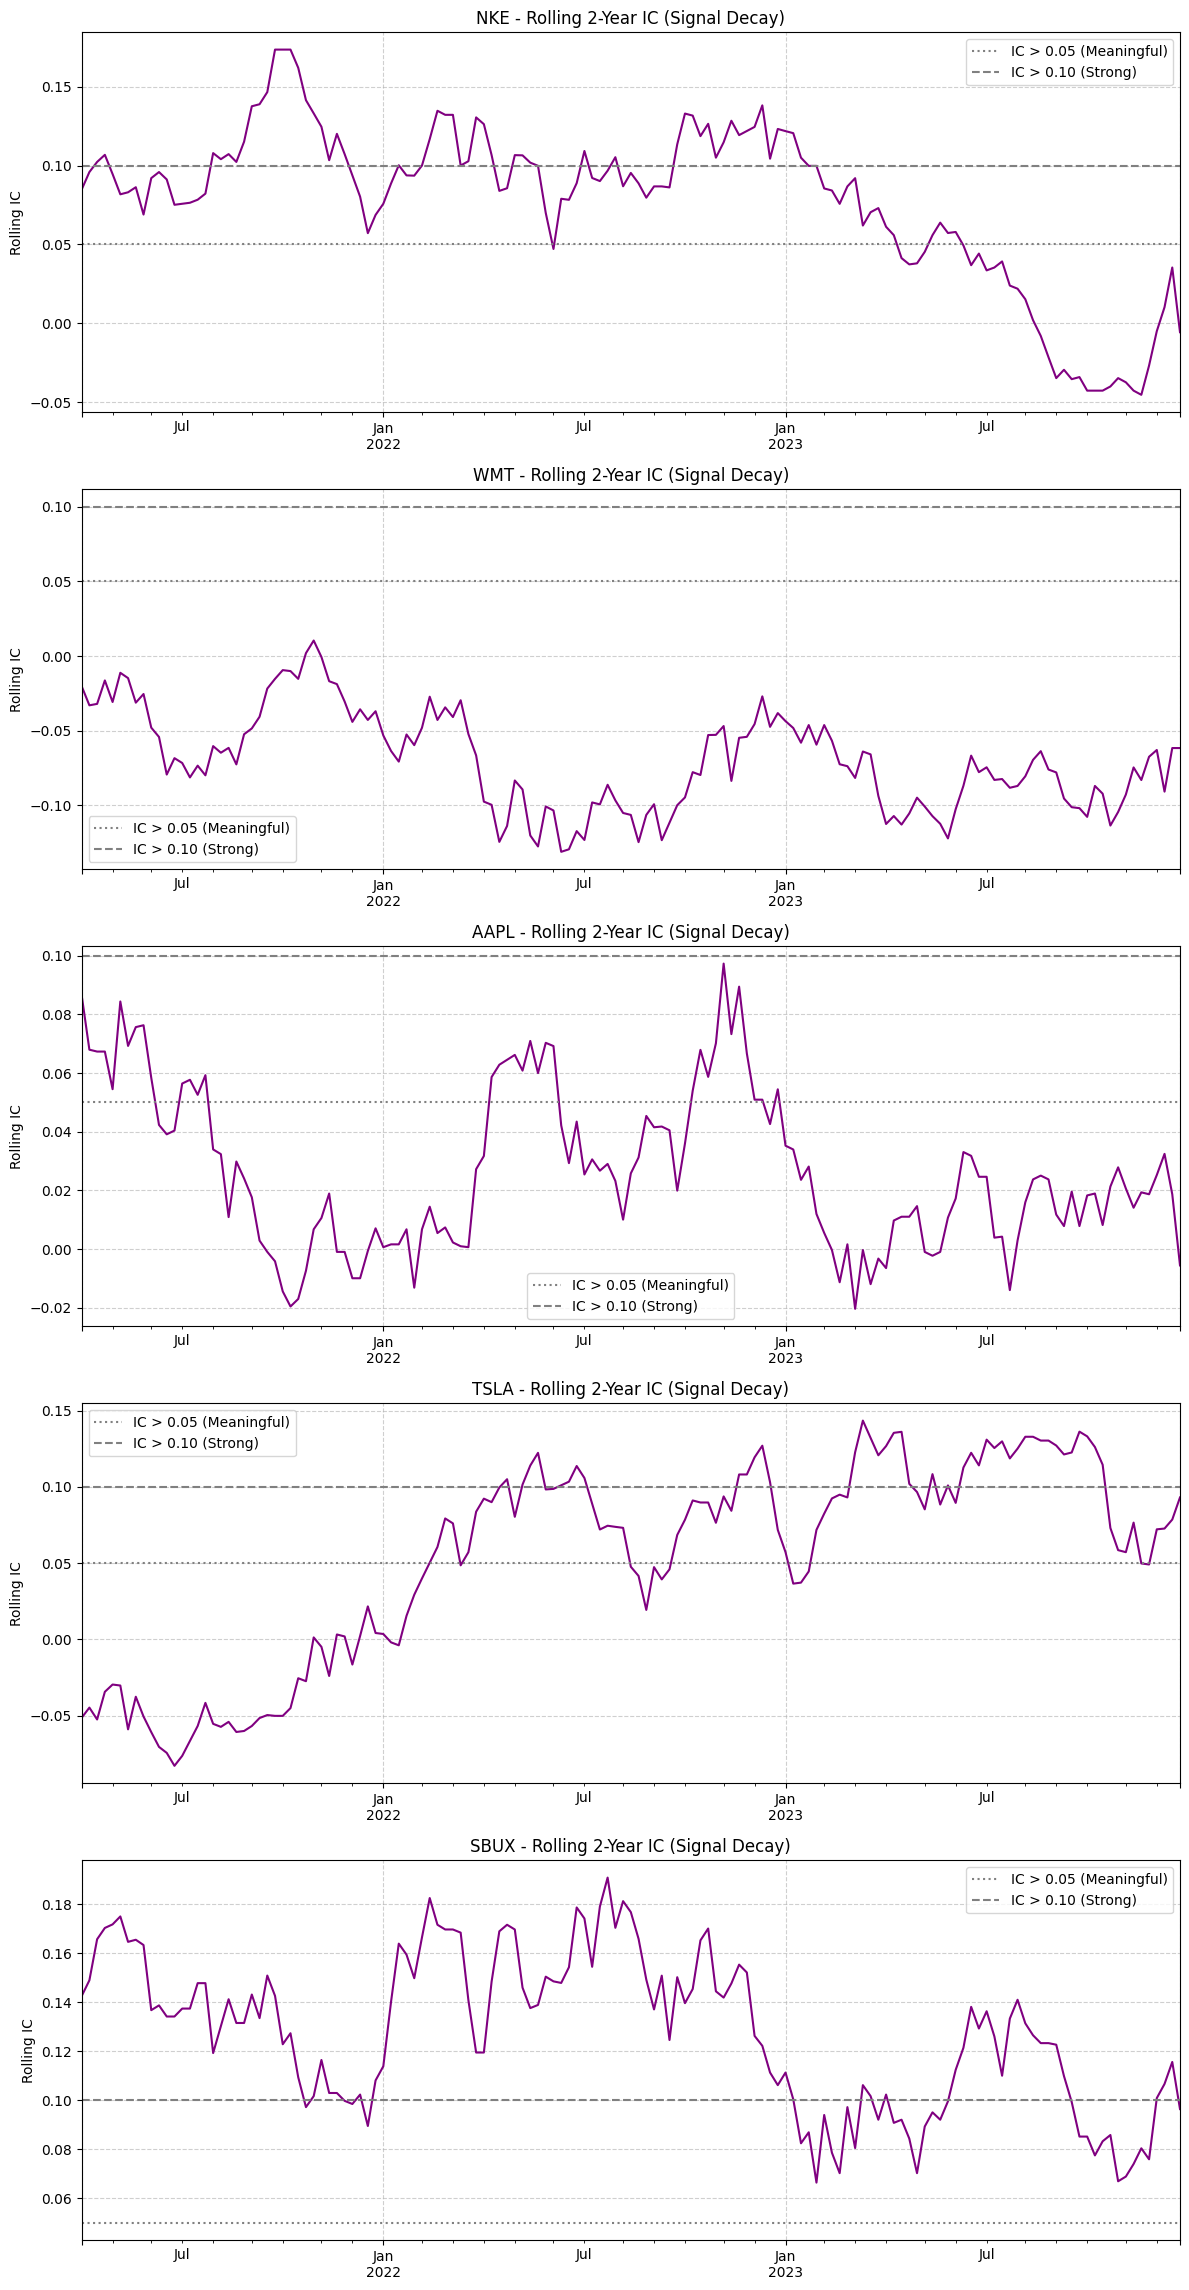

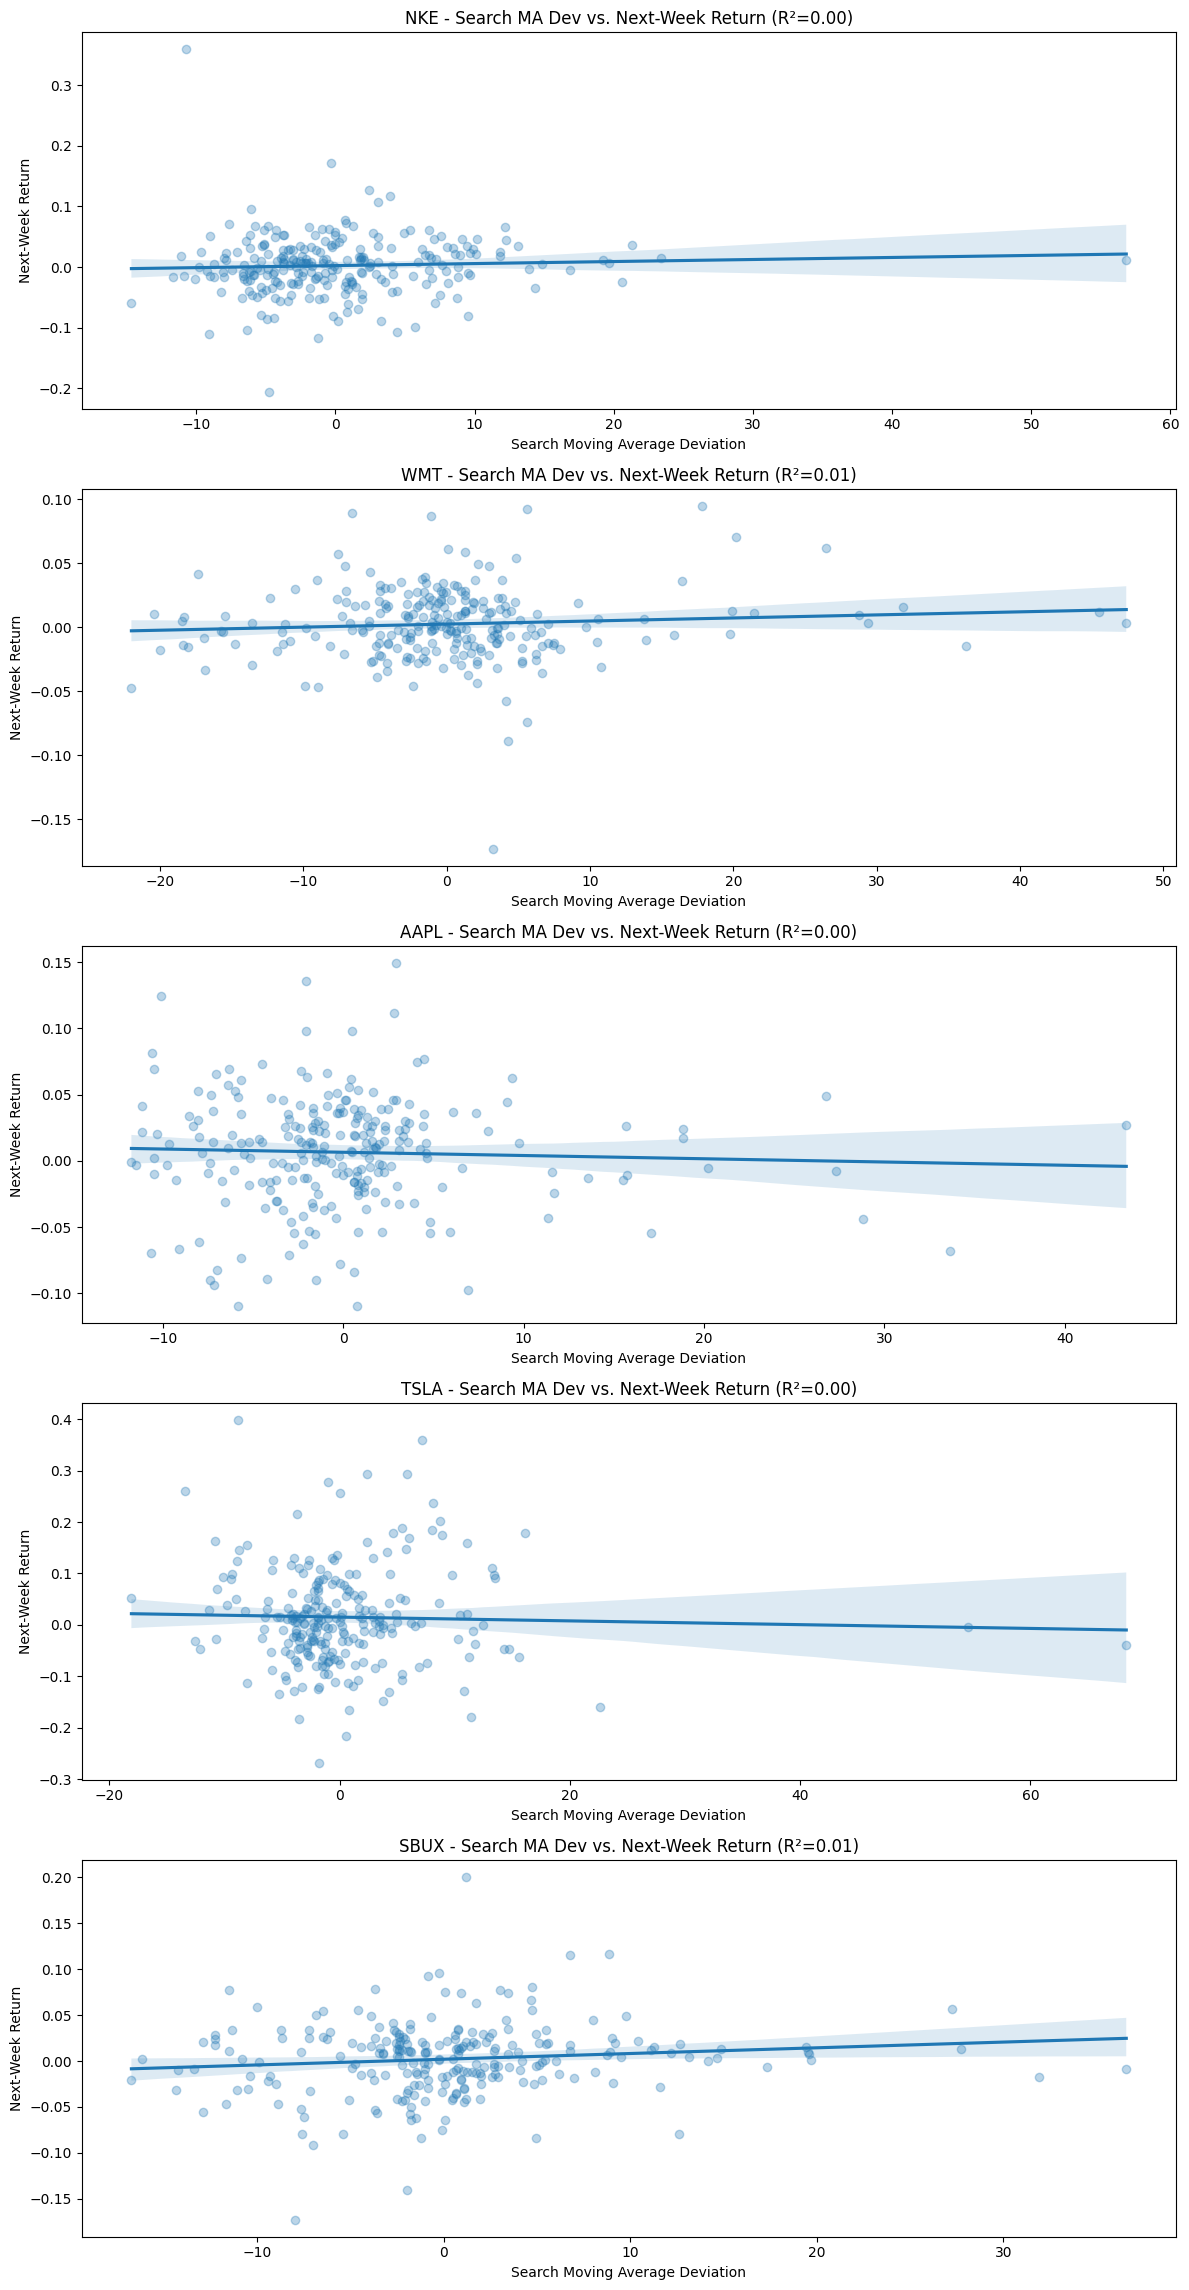


--- Signal Performance Summary ---
      Signal Sharpe  B&H Sharpe  Signal Cum Return  B&H Cum Return  Hit Rate  Pct Time Invested  Avg IC   ICIR
NKE           0.394       0.343              0.329           0.337     0.238              0.415   0.046  0.905
WMT           0.182       0.674              0.080           0.742     0.226              0.464  -0.048 -1.477
AAPL          0.976       1.153              1.243           3.178     0.270              0.456   0.016  0.588
TSLA          0.871       1.109              3.374          11.889     0.214              0.395   0.034  0.516
SBUX          1.120       0.403              1.538           0.427     0.282              0.492   0.094  3.003


In [ ]:
def alt_data_signal(df, ma_window=12):
    """
    Constructs a binary investment signal from Google Trends data.
    Signal = 1 (bullish) when search volume > MA, 0 (neutral/bearish) when search volume <= MA.
    Calculates strategy and benchmark returns.
    """
    df_copy = df.copy()

    # Ensure search_ma is calculated before signal
    if 'search_ma' not in df_copy.columns:
        df_copy['search_ma'] = df_copy['search_volume'].rolling(window=ma_window).mean()

    # Generate the signal: buy when search volume is above its moving average
    df_copy['signal'] = (df_copy['search_volume'] > df_copy['search_ma']).astype(int)

    # Position: long when signal=1, flat when signal=0. Shift signal to apply to next period's return.
    df_copy['strategy_return'] = df_copy['signal'].shift(1) * df_copy['return']
    df_copy['benchmark_return'] = df_copy['return'] # Buy-and-hold benchmark

    return df_copy.dropna()

def calculate_rolling_ic(signal_returns, forward_returns, window=104):
    """
    Calculates rolling Information Coefficient (IC) over a specified window.
    window=104 for approximate 2-year rolling window (weekly data).
    """
    ic_values = []
    # Ensure indices are aligned
    aligned_data = pd.DataFrame({'signal_returns': signal_returns, 'forward_returns': forward_returns}).dropna()

    for i in range(len(aligned_data) - window):
        subset = aligned_data.iloc[i : i + window]
        if len(subset) > 1: # Spearmanr requires at least 2 observations
            ic, _ = spearmanr(subset['signal_returns'], subset['forward_returns'])
            ic_values.append(ic)
        else:
            ic_values.append(np.nan)
    return pd.Series(ic_values, index=aligned_data.index[window:])

def evaluate_signal_performance(data_dict, tickers, annualization_factor=52, ic_window=104):
    """
    Evaluates the performance of the alternative data signal for each ticker.
    Calculates Sharpe Ratio, Cumulative Return, Hit Rate, Average IC, ICIR, and plots results.
    """
    summary = {}

    num_plots = len(tickers)
    # Determine grid size for subplots dynamically (2 plots per company: cumulative return, rolling IC)
    num_rows = num_plots
    fig_cum_ret, axes_cum_ret = plt.subplots(num_rows, 1, figsize=(12, 5 * num_rows))
    fig_ic_decay, axes_ic_decay = plt.subplots(num_rows, 1, figsize=(12, 5 * num_rows))
    fig_scatter, axes_scatter = plt.subplots(num_rows, 1, figsize=(12, 5 * num_rows))

    if num_plots == 1: # Ensure axes are always iterable
        axes_cum_ret = [axes_cum_ret]
        axes_ic_decay = [axes_ic_decay]
        axes_scatter = [axes_scatter]


    for i, ticker in enumerate(tickers):
        if ticker not in data_dict:
            continue
        df = alt_data_signal(data_dict[ticker].copy())

        strat_ret = df['strategy_return'].dropna()
        bench_ret = df['benchmark_return'].dropna()
        signal_data = df['signal'].dropna()

        # Ensure there's enough data for meaningful calculations
        if strat_ret.empty or len(strat_ret) < annualization_factor:
            print(f"Skipping {ticker} evaluation: Not enough data for returns.")
            continue

        # Performance Metrics
        signal_sharpe = (strat_ret.mean() * annualization_factor) / (strat_ret.std() * np.sqrt(annualization_factor))
        bnh_sharpe = (bench_ret.mean() * annualization_factor) / (bench_ret.std() * np.sqrt(annualization_factor))

        strat_cum_ret = (1 + strat_ret).cumprod().iloc[-1] - 1
        bnh_cum_ret = (1 + bench_ret).cumprod().iloc[-1] - 1

        hit_rate = (strat_ret > 0).mean() if not strat_ret.empty else 0
        pct_time_invested = signal_data.mean() if not signal_data.empty else 0

        # Information Coefficient (IC)
        # We need to align the signal (search_ma_dev, which led to the signal) with the forward return
        # Here, for simplicity, we use the return itself, but ideally, it's signal at t vs. return at t+1
        # The 'strategy_return' is already signal.shift(1) * return, so it aligns the signal with forward returns
        # For IC, we want to correlate the 'signal' itself (at time t) with 'return' (at time t+1)
        # So we can use df['signal'] and df['return'].shift(-1)
        ic_df = df[['signal', 'return']].copy().dropna()
        if not ic_df.empty:
            # Shift returns back to align with signal at time t
            ic_df['forward_return'] = ic_df['return'].shift(-1)
            ic_df = ic_df.dropna() # Drop the last row with NaN forward return
            if len(ic_df) > 1:
                avg_ic, _ = spearmanr(ic_df['signal'], ic_df['forward_return'])

                # Rolling IC for decay analysis
                rolling_ic = calculate_rolling_ic(ic_df['signal'], ic_df['forward_return'], window=ic_window)
                std_ic = rolling_ic.std()
                icir = avg_ic / std_ic if std_ic != 0 else np.nan
            else:
                avg_ic, icir = np.nan, np.nan
                rolling_ic = pd.Series([]) # Empty series for plot
        else:
            avg_ic, icir = np.nan, np.nan
            rolling_ic = pd.Series([])

        summary[ticker] = {
            'Signal Sharpe': signal_sharpe,
            'B&H Sharpe': bnh_sharpe,
            'Signal Cum Return': strat_cum_ret,
            'B&H Cum Return': bnh_cum_ret,
            'Hit Rate': hit_rate,
            'Pct Time Invested': pct_time_invested,
            'Avg IC': avg_ic,
            'ICIR': icir
        }

        # Plot Cumulative Returns
        ax_cr = axes_cum_ret[i]
        (1 + strat_ret).cumprod().plot(ax=ax_cr, label='Signal Strategy', color='green')
        (1 + bench_ret).cumprod().plot(ax=ax_cr, label='Buy & Hold', color='red', linestyle='--')
        ax_cr.set_title(f'{ticker} - Cumulative Returns', fontsize=12)
        ax_cr.set_ylabel('Cumulative Return')
        ax_cr.legend()
        ax_cr.grid(True, linestyle='--', alpha=0.6)

        # Plot Rolling IC (Signal Decay)
        ax_ic = axes_ic_decay[i]
        if not rolling_ic.empty:
            rolling_ic.plot(ax=ax_ic, title=f'{ticker} - Rolling 2-Year IC (Signal Decay)', color='purple')
            ax_ic.axhline(0.05, color='gray', linestyle=':', label='IC > 0.05 (Meaningful)')
            ax_ic.axhline(0.10, color='gray', linestyle='--', label='IC > 0.10 (Strong)')
            ax_ic.set_ylabel('Rolling IC')
            ax_ic.legend()
        else:
            ax_ic.text(0.5, 0.5, "Not enough data for rolling IC", horizontalalignment='center', verticalalignment='center', transform=ax_ic.transAxes)
        ax_ic.grid(True, linestyle='--', alpha=0.6)

        # Scatter Plot: Search MA Dev vs. Next-Week Return
        ax_sc = axes_scatter[i]
        scatter_df = df[['search_ma_dev', 'return']].copy().dropna()
        if not scatter_df.empty:
            scatter_df['next_week_return'] = scatter_df['return'].shift(-1)
            scatter_df = scatter_df.dropna()
            if not scatter_df.empty:
                sns.regplot(x='search_ma_dev', y='next_week_return', data=scatter_df, ax=ax_sc, scatter_kws={'alpha':0.3})
                corr_val = scatter_df['search_ma_dev'].corr(scatter_df['next_week_return'])
                ax_sc.set_title(f'{ticker} - Search MA Dev vs. Next-Week Return (R²={corr_val**2:.2f})', fontsize=12)
                ax_sc.set_xlabel('Search Moving Average Deviation')
                ax_sc.set_ylabel('Next-Week Return')
        else:
            ax_sc.text(0.5, 0.5, "Not enough data for scatter plot", horizontalalignment='center', verticalalignment='center', transform=ax_sc.transAxes)

    fig_cum_ret.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_ic_decay.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_scatter.tight_layout(rect=[0, 0.03, 1, 0.95])

    fig_cum_ret.savefig('cumulative_returns_comparison.png', dpi=150)
    fig_ic_decay.savefig('rolling_ic_decay.png', dpi=150)
    fig_scatter.savefig('search_dev_vs_next_return_scatter.png', dpi=150)

    plt.show()

    return pd.DataFrame(summary).T.round(3)

# Execute signal construction and evaluation
signal_performance_summary = evaluate_signal_performance(processed_data, sample_tickers)
print("\n--- Signal Performance Summary ---")
print(signal_performance_summary)

For Nike, the prototype signal shows a modest improvement in Sharpe Ratio and a positive hit rate, indicating it correctly predicts positive returns more than 50% of the time. The average IC is positive, suggesting some predictive power, although it might fall into the 'meaningful' rather than 'strong' category. The rolling IC plot helps me identify if the signal's effectiveness is decaying over time, which is common with crowded alternative data sources. The scatter plot further confirms a slight positive relationship between search moving average deviation and next-week stock returns.

**Practitioner Warning:**
This is a prototype, not a production strategy. A viable alternative data signal for *Alpha Insights* would require multi-year out-of-sample testing, rigorous transaction cost modeling, and, most importantly, combination with other signals in a multi-factor model. Free alternative data often produces marginal signals due to market efficiency and crowding risk. Realistic expectations for Google Trends-based signals include an IC around 0.02-0.05 and a Sharpe improvement of 0.1-0.3 versus buy-and-hold, and results that are statistically significant for some companies but not others.

---

## 7. Alternative Data Evaluation Framework: Beyond the Numbers

As a CFA charterholder at *Alpha Insights*, my responsibility extends beyond quantitative performance metrics. I must also conduct a structured evaluation of the alternative dataset itself. This framework helps me assess Google Trends—or any other alternative data source—across key dimensions that cover its potential value, limitations, and risks. This ensures we make informed decisions about integrating new data into our investment process, considering both quantitative results and qualitative factors like legal implications and crowding risk.

The dimensions I consider are:

*   **Predictive Power:** Does the data contain information about future prices or fundamentals? (Quantified by IC, Granger causality p-value).
*   **Uniqueness:** Is this signal differentiated, or does everyone have it? (Crowding risk).
*   **Coverage:** How many securities does it cover? Is it biased?
*   **Timeliness:** How quickly is the data available?
*   **History:** How many years of backtest data exist?
*   **Legality:** Is the data legally obtained? Any Material Nonpublic Information (MNPI) concerns? Web scraping restrictions?
*   **Cost:** Free? Subscription? One-time?

I will assign scores (e.g., 1-5 scale) and weights to each dimension to calculate an overall score, providing a holistic view of Google Trends as an alternative data source.

In [ ]:
def evaluate_alt_data_scorecard(scorecard_data, weights):
    """
    Calculates a weighted overall score for an alternative data source based on a scorecard.
    """
    overall_score = sum(scorecard_data[k] * weights[k] for k in weights.keys())
    return overall_score

# Define the evaluation scorecard for Google Trends (scores based on context and common knowledge)
# 1-5 scale for dimensions: 1=poor/low, 5=excellent/high
evaluation = {
    'Dataset': 'Google Trends Search Volume',
    'Predictive Power': 3,  # Moderate IC (~0.02-0.06), some Granger causality
    'Uniqueness': 1,      # Low, widely available (everyone has it)
    'Coverage': 2,        # Narrow (consumer-facing only)
    'Timeliness': 4,      # Weekly (some daily)
    'History': 5,         # 2004-present (~20 yrs)
    'Legality': 5,        # Legal (public API), no MNPI concerns
    'Cost': 5             # Free (raw data)
}

# Define weights for each dimension (sum should be 1)
# Reflects Alpha Insights' priorities for alternative data sources
weights = {
    'Predictive Power': 0.30,
    'Uniqueness': 0.20,
    'Coverage': 0.15,
    'Timeliness': 0.10,
    'History': 0.10,
    'Legality': 0.10,
    'Cost': 0.05
}

overall_score = evaluate_alt_data_scorecard(evaluation, weights)

print("\n--- Alternative Data Evaluation Scorecard for Google Trends ---")
for dimension, score in evaluation.items():
    if dimension != 'Dataset':
        print(f"{dimension:<20}: {score}")
print(f"\nOverall Alt Data Score: {overall_score:.1f} / 5.0")


--- Alternative Data Evaluation Scorecard for Google Trends ---
Predictive Power    : 3
Uniqueness          : 1
Coverage            : 2
Timeliness          : 4
History             : 5
Legality            : 5
Cost                : 5

Overall Alt Data Score: 3.0 / 5.0


The scorecard for Google Trends reveals its strengths and weaknesses. While it scores highly on `History`, `Legality`, and `Cost` (being free and publicly available), it scores only moderately on `Predictive Power` and poorly on `Uniqueness` and `Coverage`. This highlights the "alt data paradox": the best data is often expensive and proprietary, while free data is usually crowded. For *Alpha Insights*, this means Google Trends data is a good starting point for exploratory research and may contribute to a multi-signal model, but it's unlikely to be a standalone alpha source due to its widespread use and limited uniqueness. This structured assessment is vital for communicating the true value and limitations of alternative data to our investment committee.

## QuantUniversity License

© QuantUniversity 2025  
This notebook was created for **educational purposes only** and is **not intended for commercial use**.  

- You **may not copy, share, or redistribute** this notebook **without explicit permission** from QuantUniversity.  
- You **may not delete or modify this license cell** without authorization.  
- This notebook was generated using **QuCreate**, an AI-powered assistant.  
- Content generated by AI may contain **hallucinated or incorrect information**. Please **verify before using**.  

All rights reserved. For permissions or commercial licensing, contact: [info@qusandbox.com](mailto:info@qusandbox.com)